In [1]:
# Import required libraries

import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

Define ODE as:

$\dfrac{du}{dt}=\mathrm{sin}(40\,t\,u)$ s.t. $u(0)=u_0=1$.  **(1)**

That means a trial solution could be

$u_t(t,P)=h_1(t)+h_2(t, N(t,P))$  **(2)** with $N(x,P)$ as the network of weights/biases $P$. We know $u(0)=u_0$, so we can write the trial solution as:

$u_t(t,P)=u_0+tN(t,P)$  **(3)** which ensured that when $t=0$, $u_t(0)=u_0 + 0$ as desired.

Network cost function will be squared residuals $c(x,P)=\left[u_t'(t,P)-\mathrm{sin}(40\,t\,u_t(x,P))\right]^2$  **(4)** with associated minimisation problem $\mathrm{min}_P\:\left[c(x,P)\right]$

Common to use some form of automatic differentiation to process the backpropagation steps of network training. Popular library autograd has been superseded by 'jax'. Can't install jax on windows at the moment though, so stick with autograd.

In [2]:
# Equation (3)
def trialSolution(t, P, u0=1):
    return u0 + t*neural_network(P, t)

# RHS of equation (1)
def du(t, trialSolution):
    return np.sin(40 * t * trialSolution)

# Activation function for the network
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Gradient of the activation function
def sigmoid_grad(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [3]:
# Assuming one input, hidden, and output layer
def neural_network(params, t):

    # Find the weights (including and biases) for the hidden and output layer.
    # Assume that params is a list of parameters for each layer.
    # The biases are the first element for each array in params,
    # and the weights are the remaning elements in each array in params.

    w_hidden = params[0]
    w_output = params[1]

    #t = np.asarray(t)
    # Assumes input x being an one-dimensional array
    num_values = np.size(t)
    t = t.reshape(-1, num_values)
    
    # Assume that the input layer does nothing to the input t
    t_input = t

    ## Hidden layer:

    # Add a row of ones to include bias
    t_input = np.concatenate((np.ones((1, num_values)), t_input), axis = 0)

    z_hidden = np.matmul(w_hidden, t_input)
    t_hidden = sigmoid(z_hidden)

    ## Output layer:

    # Include bias:
    t_hidden = np.concatenate((np.ones((1,num_values)), t_hidden), axis = 0)

    z_output = np.matmul(w_output, t_hidden)
    t_output = z_output

    return t_output

In [4]:
# Cost function
def cost_function(P, t):

    # Evaluate the trial function with the current parameters P
    u_t = trialSolution(t, P)

    # Find the derivative w.r.t t of the neural network
    d_net_out = elementwise_grad(neural_network, 1)(P, t)

    # Find the derivative w.r.t t of the trial function
    d_g_t = elementwise_grad(trialSolution, 0)(t, P)
    
    # Error terms
    err_sqr = (d_g_t - du(t, u_t))**2
    cost_sum = np.sum(err_sqr)

    return cost_sum / np.size(err_sqr)

In [5]:
# Solve the exponential decay ODE using neural network with one input, hidden, and output layer
def solve_ode_neural_network(t, num_neurons_hidden, num_iter, lmb):
    ## Set up initial weights and biases

    # For the hidden layer
    p0 = npr.randn(num_neurons_hidden, 2)

    # For the output layer
    p1 = npr.randn(1, num_neurons_hidden + 1) # +1 since bias is included

    P = [p0, p1]

    print('Initial cost: %g'%cost_function(P, t))

    ## Start finding the optimal weights using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_grad = grad(cost_function, 0)  # arg1 is the actual function defined above.

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of two arrays;
        # one for the gradient w.r.t P_hidden and
        # one for the gradient w.r.t P_output
        cost_grad =  cost_function_grad(P, t)

        P[0] = P[0] - lmb * cost_grad[0]
        P[1] = P[1] - lmb * cost_grad[1]

    print('Final cost: %g'%cost_function(P, t))

    return P

In [6]:
# Define constants

#K = 0.01  # Step size
#tmin, tmax = 0, 1  # Domain
#N = int(tmax/K)  # Number points in time to compute
num_hidden_neurons = 20
num_iter = 10000
t = np.linspace(0, 1, 100) # Grid limits
W = [npr.randn(1,10), npr.randn(10,1)] # Randomly initialise the weights - this is where it's decided that there'll be 10 hidden nodes?
lamda = 0.001 # Gradient descent learning rate

In [7]:
# Do the network training and find the best parameters

P = solve_ode_neural_network(t, num_hidden_neurons, num_iter, lamda)  # x is a vector here

# Print the deviation from the trial solution and true solution
result = trialSolution(t, P)

Initial cost: 1.14913
Final cost: 0.508994


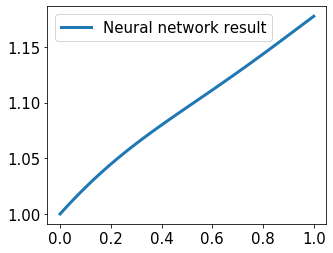

In [8]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(t, result.T, linewidth=3, label='Neural network result')
plt.legend()
plt.show()